## plot_tc_wind.ipynb
Author: Robert M. Frost

University of Oklahoma

Created 23 August 2023

Purpose: Plot timeseries of maximum wind at different vertical levels of WRF TC simulation following the TC track

In [7]:
import sys
sys.path.append("/home/robbyfrost/jhr-wrf-python/")
from mask_tc_track import mask_tc_track
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from netCDF4 import Dataset
# import wrf
# from wrf import getvar

read in stitched output and extract necessary arrays

In [21]:
# read in stitched output
ds = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/stitchd02_wrfout.nc")

# read in plev interpolated values
u_c = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/cp_interp_U").U
v_c = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/cp_interp_V").V
u_d = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/dp_interp_U").U
v_d = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/dp_interp_V").V

In [29]:
u_c["bottom_top"] = np.arange(1000,500,-50)
u_d["bottom_top"] = np.arange(1000,450,-50)
v_c["bottom_top"] = np.arange(1000,500,-50)
u_d["bottom_top"] = np.arange(1000,450,-50)

In [ ]:
# u10 = ds.U10
# v10 = ds.V10

In [30]:
lat = ds.XLAT[0].values
lon = ds.XLONG[0].values
time = ds.XTIME

expand and reorder dimensions to fit mask_tc_track function

In [ ]:
# u10 = u10.expand_dims(dim={"z":1})
# u10 = u10.transpose("Time", "z", "south_north", "west_east")
# v10 = v10.expand_dims(dim={"z":1})
# v10 = v10.transpose("Time", "z", "south_north", "west_east")

read in tc track, mask to follow track

In [33]:
# read in simulated tc track
c_sim_track = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/erin3000track_rvor.nc"
d_sim_track = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/erin_d3000track_rvor.nc"
# mask dataset to follow tc track
uc_mask = mask_tc_track(track_file=c_sim_track, rmax=1, var=u_c, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)
ud_mask = mask_tc_track(track_file=d_sim_track, rmax=1, var=u_d, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)
vc_mask = mask_tc_track(track_file=c_sim_track, rmax=1, var=v_c, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)
vd_mask = mask_tc_track(track_file=d_sim_track, rmax=1, var=v_d, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)

/home/robbyfrost/jhr-wrf-python/mask_tc_track.py:68: RuntimeWarning: overflow encountered in square
  radius3d = np.sqrt( lon3d**2 + lat3d**2 )
/home/robbyfrost/jhr-wrf-python/mask_tc_track.py:68: RuntimeWarning: invalid value encountered in sqrt
  radius3d = np.sqrt( lon3d**2 + lat3d**2 )


calculate masked windspeed

In [34]:
# wspd10 = (u10_mask ** 2 + v10_mask ** 2) ** (1/2)
wspd_c = (uc_mask ** 2 + vc_mask ** 2) ** (1/2)
wspd_d = (ud_mask ** 2 + vd_mask ** 2) ** (1/2)

/home/robbyfrost/miniconda3/envs/analysis/lib/python3.12/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


extract positional coordinates

In [35]:
y = ds.south_north
x = ds.west_east

plotting set up

In [60]:
# plotting setup

# Set the font weight for plot titles
plt.rcParams['axes.titleweight'] = 'bold'

# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='sans-serif')
# plt.rcParams['font.family'] = 'DejaVu Sans'
rc('font', weight='normal', size=17.5)
rc('figure', facecolor='white') 

import cmocean
colors = cmocean.cm.thermal

plot timeseries of max wspd

In [56]:
# wspd10_max = np.empty(time.size)
wspd_c_max = np.empty((time.size, wspd_c[0,:,0,0].size))
wspd_d_max = np.empty((time.size, wspd_d[0,:,0,0].size))

for jt in range(time.size):
    # wspd10_max[jt] = np.max(wspd10[jt], axis=(1,2))
    for jz in range(wspd_c[0,:,0,0].size):
        wspd_c_max[jt,jz] = np.max(wspd_c[jt,jz], axis=(0,1))
        wspd_d_max[jt,jz] = np.max(wspd_d[jt,jz], axis=(0,1))

/tmp/ipykernel_50262/3737086382.py:8: UserWarning: Warning: converting a masked element to nan.
  wspd_c_max[jt,jz] = np.max(wspd_c[jt,jz], axis=(0,1))
/tmp/ipykernel_50262/3737086382.py:9: UserWarning: Warning: converting a masked element to nan.
  wspd_d_max[jt,jz] = np.max(wspd_d[jt,jz], axis=(0,1))


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_50262/3120795394.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$\\bf{1^{\circ}}$ Averaged 700 mb Maximum Wind Speed")


Text(0.5, 1.0, '$\\bf{1^{\\circ}}$ Averaged 700 mb Maximum Wind Speed')

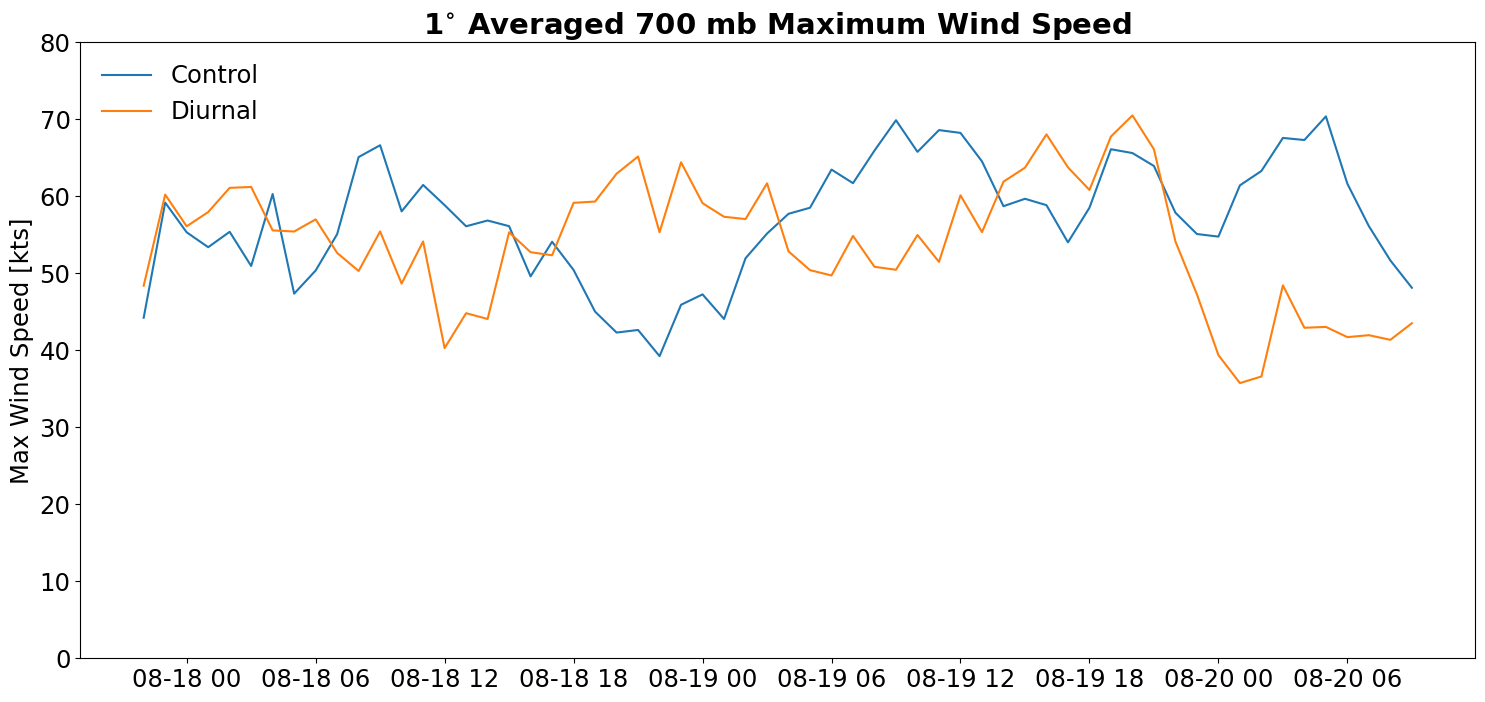

In [75]:
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(time, wspd_c_max[:,6] * 1.944, label="Control")#, c=colors[0])
ax.plot(time, wspd_d_max[:,6] * 1.944, label="Diurnal")

ax.set_ylabel("Max Wind Speed [kts]")

ax.legend(frameon=False)
ax.set_ylim(0,80)

ax.set_title("$\\bf{1^{\circ}}$ Averaged 700 mb Maximum Wind Speed")

In [58]:
# wspd10_max = np.empty(time.size)
wspd_c_mean = np.empty((time.size, wspd_c[0,:,0,0].size))
wspd_d_mean = np.empty((time.size, wspd_d[0,:,0,0].size))

for jt in range(time.size):
    # wspd10_max[jt] = np.max(wspd10[jt], axis=(1,2))
    for jz in range(wspd_c[0,:,0,0].size):
        wspd_c_mean[jt,jz] = np.mean(wspd_c[jt,jz], axis=(0,1))
        wspd_d_mean[jt,jz] = np.mean(wspd_d[jt,jz], axis=(0,1))

/tmp/ipykernel_50262/3088638299.py:8: UserWarning: Warning: converting a masked element to nan.
  wspd_c_mean[jt,jz] = np.mean(wspd_c[jt,jz], axis=(0,1))
/tmp/ipykernel_50262/3088638299.py:9: UserWarning: Warning: converting a masked element to nan.
  wspd_d_mean[jt,jz] = np.mean(wspd_d[jt,jz], axis=(0,1))


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_50262/3010475452.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$\\bf{1^{\circ}}$ Averaged 700 mb Mean Wind Speed")


Text(0.5, 1.0, '$\\bf{1^{\\circ}}$ Averaged 700 mb Mean Wind Speed')

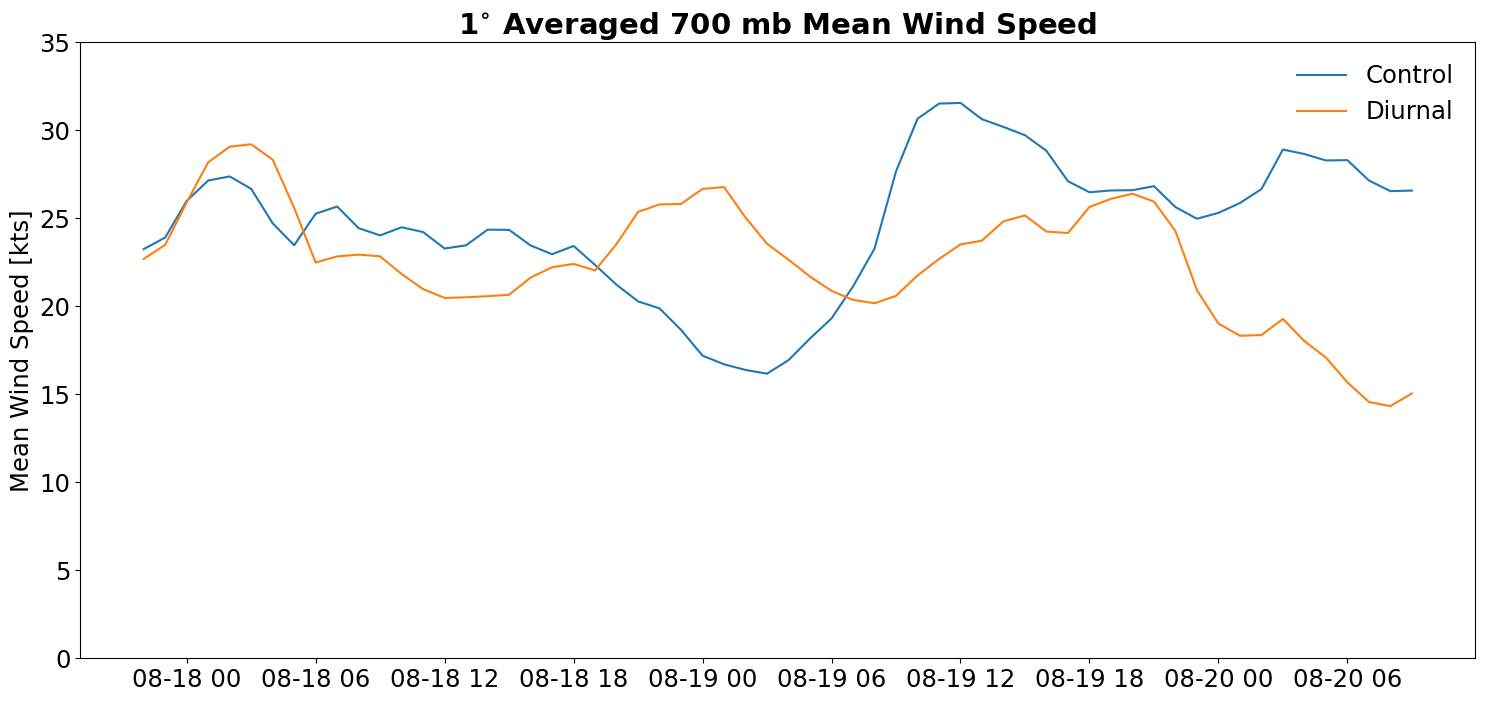

In [76]:
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(time, wspd_c_mean[:,6] * 1.944, label="Control")#, c=colors[0])
ax.plot(time, wspd_d_mean[:,6] * 1.944, label="Diurnal")

ax.set_ylabel("Mean Wind Speed [kts]")

ax.legend(frameon=False)
ax.set_ylim(0,35)

ax.set_title("$\\bf{1^{\circ}}$ Averaged 700 mb Mean Wind Speed")

plot cross section of masked wspd with wind barbs

In [ ]:
clevs = np.arange(10,51,5)

fig, ax = plt.subplots(figsize=(9,7))

c = ax.contourf(lon, lat, wspd_c[39,3] * 1.944, clevs, cmap="magma_r", extend="max")

# Wind barbs
spacing=17 #barbspacing (smaller if zoomed in)
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing],
            uc_mask[39,3,::spacing,::spacing] * 1.944, vc_mask[39,3,::spacing,::spacing] * 1.944, 
            length=6)

cbar = fig.colorbar(c)

ax.set_xlim(-99,-96.8)
ax.set_ylim(34.75,37)

ax.set_title(f"{u_c.bottom_top[3].values} mb")